In [1]:
import os
import json
import torch
import trimesh
import numpy as np
import open3d as o3d
from tqdm import tqdm 
from PIL import Image
from typing import Callable, List, Optional, Tuple
from pytorch3d.io import load_objs_as_meshes, load_obj

import pytorch3d
from pytorch3d.structures import Meshes
import pytorch3d.utils
from pytorch3d.renderer import (
    FoVPerspectiveCameras,
    PointLights,
    Materials,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    HardPhongShader,
    TexturesUV,
    TexturesVertex,
    Textures
)

from utils import *

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

print(device)

cuda:0


In [3]:
img_resolution = (256, 256)

raster_settings = RasterizationSettings(
    image_size=img_resolution,
    bin_size=None,
    blur_radius=0.0,
    faces_per_pixel=1,
)

lights = PointLights(device=device, location=[[-2.0, -2.0, -5.0]])

materials = Materials(
    device=device,
    specular_color=[[0.0, 0.0, 0.0]],
    shininess=0.0
)

rasterizer=MeshRasterizer(raster_settings=raster_settings)

# Set up a renderer.
renderer = MeshRenderer(
    rasterizer=rasterizer,
    shader=HardPhongShader(device=device, lights=lights)
)

In [4]:
def load_mesh(obj_file_path, device="cuda"):
    mesh = load_objs_as_meshes([obj_file_path], device=device)
    verts, faces = mesh.get_mesh_verts_faces(0)
    texture_rgb = torch.ones_like(verts, device=device)
    texture_rgb[:, 1:] *= 0.0  # red, by zeroing G and B
    mesh.textures = Textures(verts_rgb=texture_rgb[None])
    
    # Normalize mesh
    verts = verts - verts.mean(dim=0)
    verts /= verts.max()
    
    # This updates the pytorch3d mesh with the new vertex coordinates.
    mesh = mesh.update_padded(verts.unsqueeze(0))
    verts, faces = mesh.get_mesh_verts_faces(0)
    
    return mesh, verts, faces    

In [5]:
mesh_file_path = "stanford-bunny.obj"
mesh, verts, faces = load_mesh(mesh_file_path)

print(
    f"Loaded Mesh from : {mesh_file_path}"
    f"\nVertices: {verts.shape}"
    f"\nFaces: {faces.shape}"
)

# IGNORE Warnings and AttributeError if any

An exception occurred in telemetry logging.Disabling telemetry to prevent further exceptions.
Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/3d_env/lib/python3.10/site-packages/iopath/common/file_io.py", line 946, in __log_tmetry_keys
    handler.log_event()
  File "/home/ec2-user/anaconda3/envs/3d_env/lib/python3.10/site-packages/iopath/common/event_logger.py", line 97, in log_event
    del self._evt
AttributeError: _evt


Loaded Mesh from : stanford-bunny.obj
Vertices: torch.Size([35947, 3])
Faces: torch.Size([69451, 3])


/home/ec2-user/anaconda3/envs/3d_env/lib/python3.10/site-packages/pytorch3d/io/obj_io.py:544: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


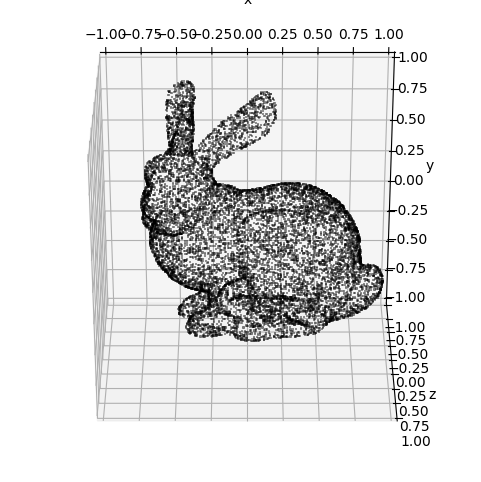

In [6]:
plot_pointcloud(verts)

In [7]:
mesh_center = torch.tensor([0.0, 0.0, 0.0], device=device)

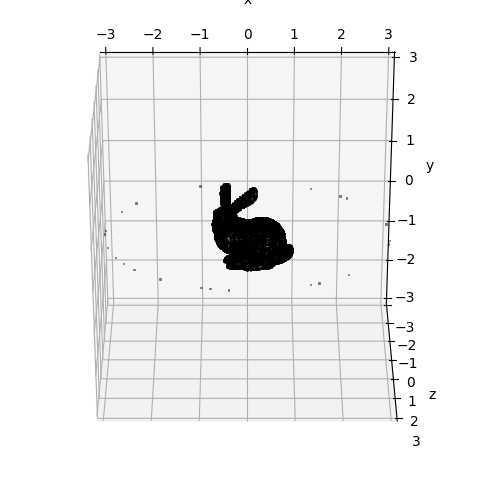

In [8]:
points = generate_camera_locations(mesh_center, 3, 100)

plot_pointcloud(torch.cat((points, verts), dim=0), xlim=(-3, 3), ylim=(-3, 3), zlim=(-3, 3))

In [9]:
R_pt3d, T_pt3d = get_look_at_views(points, mesh_center.repeat(points.shape[0], 1))

In [10]:
K_pt3d = torch.tensor([[0.7, 0., 0.5, 0.],
                        [0., 0.7, 0.5, 0.],
                        [0., 0., 0., 1.0],
                        [0., 0., 1., 0.]], device=device)

K_pt3d

tensor([[0.7000, 0.0000, 0.5000, 0.0000],
        [0.0000, 0.7000, 0.5000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 1.0000, 0.0000]], device='cuda:0')

In [ ]:
# Reconstruction

image_size = torch.tensor([img_resolution])
K = K_pt3d.unsqueeze(0)
all_meshes = list()

for idx in tqdm(range(len(points)), desc="Processing meshes"):
    # Initialize matrices
    R = R_pt3d[idx].unsqueeze(0)
    T = T_pt3d[idx].unsqueeze(0)
    
    # Define Camera
    cam = pytorch3d.renderer.cameras.PerspectiveCameras(
        R=R, 
        T=T,
        K=K,
        in_ndc=False, 
        image_size=[(1,1)],
        device=device
    )
    
    # Render image
    images = renderer(mesh, cameras=cam, lights=lights)
    image = images[0]
    
    # Depth
    fragments = rasterizer(mesh, cameras=cam)
    depths = fragments.zbuf
    depth = depths[0]
    
    #Back-Projection
    xy_pix = get_normalized_pixel_coordinates_pt3d(img_resolution[0], img_resolution[1], device=device)
    xy_pix = xy_pix.flatten(0, -2)
    depth = depth.flatten(0, -2)
    xyz = torch.cat((xy_pix, depth), dim=1)
    world_points = cam.unproject_points(xyz)    
        
    # Replacing Nan with zeros
    world_points = torch.where(torch.isnan(world_points), torch.zeros_like(world_points), world_points)
    world_points = world_points[depth.squeeze()!=-1, :]

    
    num_points, _ = world_points.shape
    H = int((num_points + 1) ** 0.5)
    W = int(num_points / H)    
    
    # Triangulation
    triangulated_mesh = get_mesh(world_space_points=world_points.T, depth=depth, H=H, W=W)

    # Append Mesh
    all_meshes.append(triangulated_mesh)

In [12]:
def simplify_mesh(mesh):
    voxel_size = 0.02
    device = "cuda"
    v = mesh.vertices
    f = mesh.faces
    dtype_v = v.dtype
    dtype_f = f.dtype
    m = o3d.geometry.TriangleMesh()
    m.vertices      = o3d.utility.Vector3dVector(v.astype(np.float64))
    m.triangles     = o3d.utility.Vector3iVector(f.astype(np.int32  ))
    m = m.simplify_vertex_clustering(voxel_size=voxel_size)
    v = np.asarray(m.vertices     ).astype(dtype_v)
    f = np.asarray(m.triangles    ).astype(dtype_f)
    v = torch.from_numpy(v).to(device=device)
    f = torch.from_numpy(f).to(device=device)
    
    mesh = trimesh.Trimesh(
        vertices = v.cpu(),
        faces = f.cpu()
    )
    return mesh

In [13]:
def merge_mesh(mesh1, mesh2):
    v1 = torch.tensor(mesh1.vertices)
    f1 = torch.tensor(mesh1.faces)
    
    v2 = torch.tensor(mesh2.vertices)
    f2 = torch.tensor(mesh2.faces)    
    
    v = torch.cat([v1, v2], dim=0)
    f = torch.cat([f1, f2 + len(v1)], dim=0)
    
    merged_mesh = trimesh.Trimesh(
        vertices = v.cpu().numpy(),
        faces = f.cpu().numpy()
    )
    
    return merged_mesh

In [14]:
# save combined mesh
mesh_combined = all_meshes[0]
for m in all_meshes[1:]:
    mesh_combined = merge_mesh(mesh_combined, m)
    # mesh_combined = simplify_mesh(mesh_combined) 

save_mesh(mesh_combined, "outputs/combined_mesh.ply")